# Principal Component Analysis (PCA)
We will implement the PCA algorithm and apply it to the MNIST digit dataset.

## Learning objective
1. Write code that implements PCA.
2. Write code that implements PCA for high-dimensional datasets

Let's first import the packages we need for this week.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.datasets import fetch_openml


## 1. PCA

Assume that we are performing PCA on some dataset $\boldsymbol X$ for $M$ principal components.  

We then need to perform the following steps:

1. Data normalization (`normalize`).
2. Find eigenvalues and corresponding eigenvectors for the covariance matrix $S$.
   Sort by the largest eigenvalues and the corresponding eigenvectors (`eig`).

After these steps, we can then compute the projection and reconstruction of the data onto the spaced spanned by the top $n$ eigenvectors.

In [2]:
def normalize(X):
    """Normalize the given dataset X
    Args:
        X: Our dataset, ndarray of size (N, D), where D is the dimension of the data,
           and N is the number of datapoints
    
    Returns:
        (Xbar, mean, std): tuple of ndarray, Xbar is the normalized dataset
        with mean 0 and standard deviation 1; mean and std are the 
        mean and standard deviation respectively.
    
    Note:
        For dimensions where the standard deviation is zero, we set it to 1 when normalizing.
    """
    mu = np.mean(X, axis=0, keepdims=True)
    std = np.std(X, axis=0, keepdims=True)
    std[std == 0] = 1
    Xbar = (X - mu) / std
    return Xbar, mu, std


In [3]:
def eig(S):
    """Compute the eigenvalues and corresponding eigenvectors 
        for the covariance matrix S.
    Args:
        S: ndarray, covariance matrix
    
    Returns:
        (eigvals, eigvecs): ndarray, the eigenvalues and eigenvectors

    Note:
        the eigenvals and eigenvecs should be sorted in descending
        order of the eigen values
    """
    eigvals, eigvecs = np.linalg.eigh(S)
    sorted_indices = np.argsort(eigvals)[::-1]
    
    return (eigvals[sorted_indices], eigvecs[::, sorted_indices])

In [4]:
def projection_matrix(B):
    """Compute the projection matrix onto the space spanned by `B`
    Args:
        B: ndarray of dimension (D, M), the basis for the subspace
    
    Returns:
        P: the projection matrix
    """
    # We assume that the columns of B are not orthonormal
    P = B @ np.linalg.inv(B.T @ B) @ B.T
    
    return P


In [5]:
def projection_matrix_optimized(B):
    """Compute the projection matrix onto the space spanned by `B`
    Args:
        B: ndarray of dimension (D, M), the basis for the subspace
    
    Returns:
        P: the projection matrix
    """
    # We assume that the columns of B are orthonormal
    P = B @ B.T
    
    return P


In [6]:
def PCA(X, num_components):
    """
    Args:
        X: ndarray of size (N, D), where D is the dimension of the data,
           and N is the number of datapoints
        num_components: the number of principal components to use.
    
    Returns:
        X_reconstruct: ndarray of the reconstruction
        of X from the first `num_components` principal components.
    """
    cov_matrix = (1 / X.shape[0]) * (X.T @ X)
    evalues, evectors = eig(cov_matrix)
    proj_matrix = projection_matrix_optimized(evectors[:, :num_components])
    X_reconstruct = X @ proj_matrix.T
    
    return X_reconstruct

### Apply PCA on MNIST dataset

Before we implement PCA, we will need to do some data preprocessing. 

The preprocessing steps we will do are
1. Convert unsigned interger 8 (uint8) encoding of pixels to a floating point number between 0-1.
2. Subtract from each image the mean $\boldsymbol \mu$.
3. Scale each dimension of each image by $\frac{1}{\sigma}$ where $\sigma$ is the stardard deviation.

The steps above ensure that our images will have zero mean and one variance. These preprocessing
steps are also known as [Data Normalization or Feature Scaling](https://en.wikipedia.org/wiki/Feature_scaling).

In [7]:
mnist = fetch_openml('mnist_784')

images, labels = mnist['data'], mnist['target']

images.shape

(70000, 784)

Now, let's plot a digit from the dataset:

In [8]:
@interact(index=(0, 70000))
def plotter(index):
    plt.figure(figsize=(1, 1))
    plt.imshow(images[index].reshape(28, 28), cmap='gray')

interactive(children=(IntSlider(value=35000, description='index', max=70000), Output()), _dom_classes=('widget…

In [9]:
# Normalize the data

X = images.reshape(-1, 28 * 28)
Xbar, mu, std = normalize(X)

In [10]:
from sklearn.decomposition import PCA as SKPCA

for num_component in range(1, 50, 10):
    # We can compute a standard solution given by scikit-learn's implementation of PCA
    pca = SKPCA(n_components=num_component, svd_solver='full')
    %time sklearn_reconst = pca.inverse_transform(pca.fit_transform(Xbar))
    # this is our implementation
    %time reconst = PCA(Xbar, num_component)
    np.testing.assert_almost_equal(reconst, sklearn_reconst)
    print(np.square(reconst - sklearn_reconst).sum())

Wall time: 5.09 s
Wall time: 716 ms
1.4937700576426302e-22
Wall time: 5.16 s
Wall time: 784 ms
1.3697091124119802e-21
Wall time: 5.05 s
Wall time: 832 ms
2.2557587350553455e-21
Wall time: 5.14 s
Wall time: 830 ms
3.9076177863806e-21
Wall time: 5.16 s
Wall time: 819 ms
3.8846701596871895e-21


The greater number of of principal components we use, the smaller will our reconstruction
error be. Now, let's answer the following question: 


> How many principal components do we need
> in order to reach a Mean Squared Error (MSE) of less than $100$ for our dataset?



We have provided a function in the next cell which computes the mean squared error (MSE), which will be useful for answering the question above.

In [14]:
def mse(predict, actual):
    """Helper function for computing the mean squared error (MSE)"""
    
    return np.square(predict - actual).sum(axis=1).mean()

In [17]:
loss = []

# iterate over different number of principal components, and compute the MSE over the dataset
for num_components in range(1, 100):
    reconst = PCA(Xbar, num_components)
    error = mse(reconst, Xbar)
    loss.append((num_components, error))

loss = np.asarray(loss)


In [18]:
# create a table showing the number of principal components and MSE
pd.DataFrame(loss, columns=['Number of principal components', 'Mean squared reconstruction error']).head(5)

,Number of principal components,Mean squared reconstruction error
0,1.0,678.428851
1,2.0,649.372437
2,3.0,622.494252
3,4.0,601.693584
4,5.0,583.569379


We can also put these numbers into perspective by plotting them.

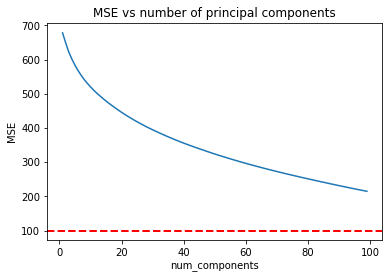

In [19]:
fig, ax = plt.subplots()

ax.plot(loss[:, 0], loss[:, 1])

ax.axhline(100, linestyle='--', color='r', linewidth=2)
ax.set(xlabel='num_components', ylabel='MSE', title='MSE vs number of principal components');


But _numbers dont't tell us everything_! Just what does it mean _qualitatively_ for the loss to decrease?

Let's find out! In the next cell, we draw the the leftmost image is the original dight. Then we show the reconstruction of the image on the right, in descending number of principal components used.

In [20]:
cov_matrix = (1 / Xbar.shape[0]) * (Xbar.T @ Xbar)
evalues, evectors = eig(cov_matrix)

@interact(image_idx=(0, 500))
def show_num_components_reconst(image_idx):
    fig, ax = plt.subplots(figsize=(14, 14))
    reconstructions = []
    actual = Xbar[image_idx]
    reconstructions.append((actual * std + mu).reshape(-1, 28, 28))
    
    for components in range(100):
        proj_matrix = projection_matrix_optimized(evectors[:, :components])
        reconstructed = actual @ proj_matrix.T
        reconstructions.append((reconstructed * std + mu).reshape(-1, 28, 28))
    
    stacked = np.block([[reconstructions[10 * j + i] for i in range(10)] for j in range(9)])
    stacked = stacked.squeeze()
    ax.imshow(stacked, cmap='gray')
    

interactive(children=(IntSlider(value=250, description='image_idx', max=500), Output()), _dom_classes=('widget…

We can also browse throught the reconstructions for other digits. Once again, `interact` becomes handy for visualing the reconstruction.

In [23]:
@interact(i=(0, 999))
def show_pca_digits(i=1):
    """Show the i th digit and its reconstruction"""
    plt.figure(figsize=(3, 3))
    
    actual_sample = X[i].reshape(28, 28)
    reconst_sample = np.real((reconst[i, :] * std + mu).reshape(28, 28))
    
    plt.imshow(np.hstack([actual_sample, reconst_sample]), cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=1, description='i', max=999), Output()), _dom_classes=('widget-interact'…

## 2. PCA for high-dimensional datasets

Sometimes, the dimensionality of our dataset may be larger than the number of samples we
have. Then it might be inefficient to perform PCA with your implementation above. Instead,
as mentioned in the lectures, you can implement PCA in a more efficient manner, which we
call "PCA for high dimensional data" (PCA_high_dim).

Below are the steps for performing PCA for high dimensional dataset
1. Compute the matrix $XX^T$ (a $N$ by $N$ matrix with $N << D$)
2. Compute eigenvalues $\lambda$s and eigenvectors $V$ for $XX^T$
3. Compute the eigenvectors for the original covariance matrix as $X^TV$. Choose the eigenvectors associated with the M largest eigenvalues to be the basis of the principal subspace $U$.
4. Compute the orthogonal projection of the data onto the subspace spanned by columns of $U$. Functions you wrote for earlier assignments will be useful.

In [18]:
# GRADED FUNCTION: DO NOT EDIT THIS LINE
### PCA for high dimensional datasets

def PCA_high_dim(X, num_components):
    """Compute PCA for small sample size but high-dimensional features. 
    Args:
        X: ndarray of size (N, D), where D is the dimension of the sample,
           and N is the number of samples
        num_components: the number of principal components to use.
    Returns:
        X_reconstruct: (N, D) ndarray. The reconstruction
        of X from the first `num_components` principal components.
    """
    NN_matrix = X @ X.T
    evalues, evectors = eig(NN_matrix)
    
    # Recover our original eigenvectors of the covariance matrix
    cov_evectors = X.T @ evectors
    
    # Normalize recovered eigenvectors
    e_norm = np.linalg.norm(cov_evectors, axis=0, keepdims=True)
    cov_evectors = cov_evectors / e_norm
    
    # Create the projection matrix and the projected/reconstructed dataset
    proj_matrix = projection_matrix(cov_evectors[:, :num_components])
    X_reconstruct = (proj_matrix @ X.T).T
    
    return X_reconstruct

Given the same dataset, `PCA_high_dim` and `PCA` should give the same output. 
Assuming we have implemented `PCA`, correctly, we can then use `PCA` to test the correctness
of `PCA_high_dim`. Given the same dataset, `PCA` and `PCA_high_dim` should give identical results.

We can use this __invariant__
to test our implementation of PCA_high_dim, assuming that we have correctly implemented `PCA`.

In [19]:
np.testing.assert_almost_equal(PCA(Xbar, 2), PCA_high_dim(Xbar, 2))

Now let's compare the running time between `PCA` and `PCA_high_dim`.

__Tips__ for running benchmarks or computationally expensive code:

When you have some computation that takes up a non-negligible amount of time. Try separating
the code that produces output from the code that analyzes the result (e.g. plot the results, comput statistics of the results). In this way, you don't have to recompute when you want to produce more analysis.

The next cell includes a function that records the time taken for executing a function `f` by repeating it for `repeat` number of times. You do not need to modify the function but you can use it to compare the running time for functions which you are interested in knowing the running time.

In [20]:
def time(f, repeat=10):
    times = []
    for _ in range(repeat):
        start = timeit.default_timer()
        f()
        stop = timeit.default_timer()
        times.append(stop-start)
    return np.mean(times), np.std(times)

We first benchmark the time taken to compute $\boldsymbol X^T\boldsymbol X$ and $\boldsymbol X\boldsymbol X^T$. Jupyter's magic command `%time` is quite handy.

The next cell finds the running time for computing $X^TX$ and $XX^T$ for different dimensions of X.

In [21]:
times_mm0 = []
times_mm1 = []

# iterate over datasets of different size
for datasetsize in np.arange(4, 784, step=20):
    XX = Xbar[:datasetsize] # select the first `datasetsize` samples in the dataset
    # record the running time for computing X.T @ X
    mu, sigma = time(lambda : XX.T @ XX)
    times_mm0.append((datasetsize, mu, sigma))
    
    # record the running time for computing X @ X.T
    mu, sigma = time(lambda : XX @ XX.T)
    times_mm1.append((datasetsize, mu, sigma))
    
times_mm0 = np.asarray(times_mm0)
times_mm1 = np.asarray(times_mm1)

Having recorded the running time for computing `X @ X.T` and `X @ X.T`, we can plot them.

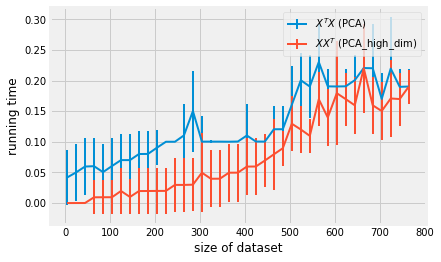

In [22]:
fig, ax = plt.subplots()
ax.set(xlabel='size of dataset', ylabel='running time')
bar = ax.errorbar(times_mm0[:, 0], times_mm0[:, 1], times_mm0[:, 2], label="$X^T X$ (PCA)", linewidth=2)
ax.errorbar(times_mm1[:, 0], times_mm1[:, 1], times_mm1[:, 2], label="$X X^T$ (PCA_high_dim)", linewidth=2)
ax.legend();

Alternatively, use the `time` magic command for benchmarking functions.

In [23]:
%time Xbar.T @ Xbar
%time Xbar @ Xbar.T
pass # Put this here so that our output does not show result of computing `Xbar @ Xbar.T`

CPU times: user 95.2 ms, sys: 87.7 ms, total: 183 ms
Wall time: 323 ms
CPU times: user 76.1 ms, sys: 122 ms, total: 198 ms
Wall time: 400 ms


Next we benchmark PCA, PCA_high_dim.

In [24]:
times0 = []
times1 = []

# iterate over datasets of different size
for datasetsize in np.arange(4, 784, step=100):
    XX = Xbar[:datasetsize]
    npc = 2
    mu, sigma = time(lambda : PCA(XX, npc), repeat=10)
    times0.append((datasetsize, mu, sigma))
    
    mu, sigma = time(lambda : PCA_high_dim(XX, npc), repeat=10)
    times1.append((datasetsize, mu, sigma))
    
times0 = np.asarray(times0)
times1 = np.asarray(times1)

Let's plot the running time. Spend some time and think about what this plot means. We mentioned in lectures that PCA_high_dim are advantageous when
we have dataset size $N$ < data dimension $M$. Although our plot does not for the two running time does not intersect exactly at $N = M$, it does show the trend.

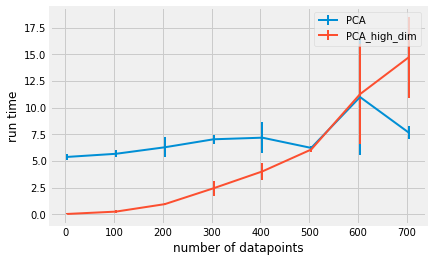

In [25]:
fig, ax = plt.subplots()
ax.set(xlabel='number of datapoints', ylabel='run time')
ax.errorbar(times0[:, 0], times0[:, 1], times0[:, 2], label="PCA", linewidth=2)
ax.errorbar(times1[:, 0], times1[:, 1], times1[:, 2], label="PCA_high_dim", linewidth=2)
ax.legend();

Again, with the magic command `time`.

In [31]:
%time PCA(Xbar[:100], 25)
%time PCA_high_dim(Xbar[:100], 25)
pass

CPU times: user 1.23 s, sys: 1.73 s, total: 2.96 s
Wall time: 5.97 s
CPU times: user 91.6 ms, sys: 34.1 ms, total: 126 ms
Wall time: 298 ms
